In [1]:
import os
import gc
from typing import NamedTuple, Optional
from fastcore.all import *

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    import sys
    sys.path.append("../input/timmmaster")
    path = Path("../input/nike-adidas-and-converse-imaged")
else:
    path = Path(os.environ["PROJECTS"])/"shoes-classifier"

import timm
from fastai.vision.all import *
import torch

(path).ls()

(#2) [Path('../input/nike-adidas-and-converse-imaged/test'),Path('../input/nike-adidas-and-converse-imaged/train')]

In [2]:
def train(n_epochs, arch, item=None, batch=None, accum=None, bs=64, cbs=None, **fine_tune):
    bs_accum = bs//accum if accum else bs
    cbs = cbs if cbs is not None else []
    if accum:
        cbs.append(GradientAccumulation(bs))
        
    dls = ImageDataLoaders.from_folder(
        path=path, train="train", valid="test", item_tfms=item, bs=bs_accum
    )

    learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
    if iskaggle:
        learn.path = Path("/kaggle/working")
    learn.fine_tune(n_epochs, 1e-2, **fine_tune)
    return dls, learn

def tta(learn):
    preds, targs = learn.get_preds(dl=learn.dls.valid)
    preds_tta, _ = learn.tta(dl=dls.valid)
    return preds, preds_tta, targs

def cleanup(tmp):
    del tmp
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
frozen_epochs = (1, 5)
batch_tfms = (
    None,
    [Rotate(max_deg=15)],
    [Zoom(min_zoom=.8,max_zoom=1.2)],
    [Rotate(max_deg=15), Zoom(min_zoom=.8,max_zoom=1.2)],
)

In [4]:
arch = "convnext_small_in22k"
for epochs, batch in itertools.product(frozen_epochs, batch_tfms):
    print(arch, epochs, batch)
    _ = train(10, arch=arch,freeze_epochs=epochs, batch=batch)
    cleanup(_)
    print("----------------------------------------------")

convnext_small_in22k 1 None


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.162607,1.896914,0.210526,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.376832,0.470157,0.105263,00:12
1,0.272804,0.440677,0.105263,00:12
2,0.199492,0.301102,0.087719,00:12
3,0.147125,0.240365,0.078947,00:12
4,0.108879,0.388843,0.105263,00:12
5,0.084527,0.268417,0.070175,00:12
6,0.065818,0.339374,0.105263,00:12
7,0.053402,0.333152,0.078947,00:12
8,0.041952,0.322444,0.070175,00:12
9,0.033537,0.323039,0.078947,00:12


----------------------------------------------
convnext_small_in22k 1 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,1.187275,0.690203,0.131579,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.330733,0.445208,0.114035,00:12
1,0.229800,0.263589,0.087719,00:12
2,0.161758,0.213575,0.052632,00:12
3,0.133437,0.371978,0.105263,00:12
4,0.112579,0.420281,0.096491,00:12
5,0.085685,0.342187,0.096491,00:12
6,0.066611,0.306341,0.087719,00:12
7,0.054101,0.268373,0.096491,00:12
8,0.042106,0.261380,0.078947,00:12
9,0.033732,0.260491,0.078947,00:12


----------------------------------------------
convnext_small_in22k 1 [Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,1.070994,0.719446,0.114035,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.293765,0.429777,0.114035,00:12
1,0.210733,0.353427,0.114035,00:12
2,0.174465,0.285731,0.087719,00:12
3,0.151558,0.273748,0.078947,00:12
4,0.120382,0.281698,0.078947,00:12
5,0.090989,0.300815,0.087719,00:12
6,0.071860,0.315601,0.096491,00:12
7,0.055865,0.333483,0.087719,00:12
8,0.045773,0.336450,0.078947,00:12
9,0.037035,0.338856,0.070175,00:12


----------------------------------------------
convnext_small_in22k 1 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: , Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.971787,1.077455,0.192982,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.238332,0.599896,0.131579,00:12
1,0.185282,0.307706,0.087719,00:12
2,0.150929,0.470835,0.131579,00:12
3,0.142629,0.512461,0.078947,00:12
4,0.158322,0.333709,0.096491,00:12
5,0.129180,0.335106,0.087719,00:12
6,0.104221,0.314975,0.078947,00:12
7,0.081635,0.317827,0.078947,00:12
8,0.064339,0.308994,0.078947,00:12
9,0.051985,0.305032,0.078947,00:12


----------------------------------------------
convnext_small_in22k 5 None


epoch,train_loss,valid_loss,error_rate,time
0,1.344176,0.536693,0.175439,00:08
1,0.823378,0.268831,0.087719,00:09
2,0.545024,0.289403,0.087719,00:09
3,0.391121,0.393716,0.096491,00:09
4,0.293803,0.343998,0.096491,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.072101,0.298651,0.078947,00:12
1,0.055179,0.229439,0.087719,00:12
2,0.049456,0.370294,0.096491,00:12
3,0.057559,0.479746,0.105263,00:12
4,0.060078,0.447526,0.096491,00:12
5,0.054612,0.460534,0.131579,00:12
6,0.047446,0.476651,0.114035,00:12
7,0.041694,0.478762,0.096491,00:12
8,0.034258,0.473324,0.096491,00:12
9,0.028318,0.466063,0.096491,00:12


----------------------------------------------
convnext_small_in22k 5 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,1.236385,1.039244,0.298246,00:09
1,0.824014,0.346944,0.105263,00:08
2,0.560902,0.300532,0.061404,00:09
3,0.393739,0.335395,0.114035,00:09
4,0.293676,0.346024,0.078947,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.060262,0.236682,0.070175,00:12
1,0.046843,0.289444,0.078947,00:12
2,0.041744,0.333779,0.078947,00:12
3,0.065109,0.362681,0.105263,00:12
4,0.102969,0.263838,0.087719,00:12
5,0.091236,0.171210,0.035088,00:12
6,0.071267,0.164869,0.035088,00:12
7,0.055929,0.153378,0.035088,00:12
8,0.047094,0.157392,0.035088,00:12
9,0.042229,0.156393,0.035088,00:12


----------------------------------------------
convnext_small_in22k 5 [Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,1.465643,1.027897,0.298246,00:09
1,0.956306,0.338434,0.096491,00:08
2,0.632121,0.333956,0.105263,00:09
3,0.443595,0.392369,0.114035,00:09
4,0.337582,0.366310,0.122807,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.050482,0.268438,0.078947,00:12
1,0.043175,0.280639,0.105263,00:12
2,0.056215,0.266771,0.096491,00:12
3,0.084606,0.529432,0.140351,00:12
4,0.099796,0.286614,0.070175,00:12
5,0.084460,0.312953,0.070175,00:12
6,0.067505,0.329499,0.078947,00:12
7,0.053240,0.318879,0.070175,00:12
8,0.042613,0.315730,0.070175,00:12
9,0.035230,0.312978,0.070175,00:12


----------------------------------------------
convnext_small_in22k 5 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: , Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,1.295056,1.097856,0.350877,00:09
1,0.790534,0.358222,0.078947,00:08
2,0.530578,0.397614,0.131579,00:09
3,0.388907,0.359870,0.122807,00:08
4,0.296464,0.300830,0.070175,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.062299,0.320162,0.070175,00:12
1,0.052091,0.303831,0.070175,00:12
2,0.057278,0.243529,0.061404,00:12
3,0.049608,0.334408,0.087719,00:12
4,0.061070,0.410221,0.061404,00:12
5,0.071758,0.409641,0.070175,00:12
6,0.068353,0.479451,0.087719,00:12
7,0.055357,0.406124,0.070175,00:12
8,0.044344,0.373390,0.070175,00:12
9,0.036511,0.366302,0.070175,00:12


----------------------------------------------
convnext_large_in22k 1 None


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.925978,0.466902,0.131579,00:23


epoch,train_loss,valid_loss,error_rate,time


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 15.90 GiB total capacity; 14.23 GiB already allocated; 63.75 MiB free; 15.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [6]:
arch = "convnext_large_in22k"
for epochs, batch in itertools.product(frozen_epochs, batch_tfms):
    print(arch, epochs, batch)
    _ = train(10, arch=arch,freeze_epochs=epochs, batch=batch, bs=66, accum=3)
    cleanup(_)
    print("----------------------------------------------")

convnext_large_in22k 1 None


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.960274,0.490255,0.114035,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.190588,0.187724,0.052632,00:34
1,0.169418,0.259254,0.096491,00:34
2,0.144801,0.203997,0.052632,00:34
3,0.125380,0.224654,0.043860,00:34
4,0.089309,0.254844,0.043860,00:34
5,0.070449,0.198235,0.052632,00:34
6,0.046262,0.255114,0.043860,00:34
7,0.030198,0.238775,0.043860,00:34
8,0.024406,0.249626,0.043860,00:34
9,0.013691,0.248247,0.043860,00:34


----------------------------------------------
convnext_large_in22k 1 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.805464,0.366086,0.105263,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.234294,0.283707,0.078947,00:34
1,0.159089,0.204957,0.035088,00:34
2,0.170870,0.315931,0.070175,00:34
3,0.168604,0.258700,0.052632,00:34
4,0.131514,0.274895,0.070175,00:34
5,0.089018,0.214492,0.035088,00:34
6,0.056773,0.248511,0.052632,00:34
7,0.037055,0.218487,0.052632,00:34
8,0.025157,0.184959,0.052632,00:34
9,0.016347,0.182398,0.043860,00:34


----------------------------------------------
convnext_large_in22k 1 [Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.826444,0.537221,0.105263,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.285831,0.194487,0.061403,00:34
1,0.196159,0.228085,0.061403,00:34
2,0.180407,0.383271,0.070175,00:34
3,0.143278,0.318576,0.070175,00:34
4,0.114127,0.114509,0.026316,00:34
5,0.097290,0.387325,0.043860,00:34
6,0.085590,0.152598,0.035088,00:34
7,0.063079,0.160572,0.017544,00:34
8,0.047280,0.149088,0.026316,00:34
9,0.037184,0.147675,0.026316,00:34


----------------------------------------------
convnext_large_in22k 1 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: , Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.896933,0.374916,0.078947,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.329581,0.294623,0.070175,00:34
1,0.222008,0.391124,0.096491,00:34
2,0.150807,0.275523,0.070175,00:34
3,0.169629,0.517870,0.096491,00:34
4,0.133248,0.238507,0.052632,00:34
5,0.105658,0.344152,0.070175,00:34
6,0.075847,0.224426,0.035088,00:34
7,0.044191,0.199824,0.043860,00:34
8,0.029630,0.196163,0.043860,00:34
9,0.023460,0.177238,0.026316,00:34


----------------------------------------------
convnext_large_in22k 5 None


epoch,train_loss,valid_loss,error_rate,time
0,0.827139,0.307414,0.114035,00:24
1,0.470444,0.224372,0.061403,00:23
2,0.341474,0.278628,0.061403,00:23
3,0.279001,0.271423,0.078947,00:24
4,0.232021,0.353509,0.061403,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.169276,0.189932,0.061403,00:34
1,0.102864,0.197824,0.026316,00:34
2,0.108645,0.319419,0.043860,00:34
3,0.126205,0.128844,0.043860,00:34
4,0.105863,0.370102,0.052632,00:34
5,0.084843,0.324707,0.043860,00:34
6,0.078214,0.249515,0.052632,00:34
7,0.052062,0.311507,0.052632,00:34
8,0.042063,0.244660,0.043860,00:34
9,0.031351,0.235307,0.043860,00:34


----------------------------------------------
convnext_large_in22k 5 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.787440,0.243620,0.078947,00:23
1,0.402641,0.272142,0.070175,00:23
2,0.265615,0.227051,0.070175,00:24
3,0.240452,0.248925,0.061403,00:23
4,0.209117,0.223743,0.052632,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.113565,0.285723,0.070175,00:33
1,0.143738,0.231032,0.052632,00:34
2,0.141319,0.202138,0.070175,00:34
3,0.178698,0.232541,0.052632,00:34
4,0.127115,0.347957,0.061403,00:34
5,0.088233,0.219896,0.043860,00:34
6,0.054748,0.150788,0.035088,00:34
7,0.040365,0.161689,0.035088,00:34
8,0.028858,0.139744,0.052632,00:34
9,0.023431,0.142241,0.043860,00:34


----------------------------------------------
convnext_large_in22k 5 [Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.834080,0.328552,0.105263,00:23
1,0.414336,0.351220,0.052632,00:23
2,0.274683,0.346493,0.087719,00:23
3,0.244493,0.705495,0.070175,00:23
4,0.263570,0.506179,0.078947,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.128903,0.394496,0.061403,00:33
1,0.132171,0.437772,0.061403,00:34
2,0.206368,0.493983,0.087719,00:34
3,0.187051,0.229428,0.035088,00:34
4,0.130792,0.234329,0.052632,00:34
5,0.118720,0.126806,0.017544,00:34
6,0.103220,0.139062,0.026316,00:34
7,0.067221,0.179188,0.043860,00:34
8,0.050974,0.166233,0.035088,00:34
9,0.039278,0.156992,0.035088,00:34


----------------------------------------------
convnext_large_in22k 5 [Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: , Zoom -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]


epoch,train_loss,valid_loss,error_rate,time
0,0.778010,0.301766,0.078947,00:23
1,0.446931,0.491511,0.114035,00:23
2,0.294870,0.341703,0.087719,00:23
3,0.281173,0.323632,0.070175,00:23
4,0.287924,0.512204,0.078947,00:23


epoch,train_loss,valid_loss,error_rate,time
0,0.133481,0.239891,0.052632,00:33
1,0.084572,0.406082,0.070175,00:34
2,0.131919,0.441380,0.052632,00:34
3,0.157601,0.466901,0.043860,00:34
4,0.138538,0.337797,0.061403,00:34
5,0.132053,0.223125,0.043860,00:34
6,0.086902,0.248661,0.043860,00:34
7,0.057313,0.257643,0.052632,00:34
8,0.039333,0.253943,0.043860,00:34
9,0.031119,0.273814,0.052632,00:34


----------------------------------------------


## Train the final model

In [4]:
dls, learn = train(
    10, freeze_epochs=5, arch="convnext_large_in22k", accum=3, bs=66,
    batch=[Zoom(min_zoom=.8,max_zoom=1.2)],
    cbs=[SaveModelCallback(monitor="error_rate")]
)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_large_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.973437,0.328732,0.096491,00:30
1,0.517086,0.227966,0.052632,00:23
2,0.291923,0.164044,0.035088,00:23
3,0.176703,0.223171,0.052632,00:23
4,0.115359,0.251981,0.061403,00:23


Better model found at epoch 0 with error_rate value: 0.09649119526147842.
Better model found at epoch 1 with error_rate value: 0.05263155326247215.
Better model found at epoch 2 with error_rate value: 0.03508768603205681.


epoch,train_loss,valid_loss,error_rate,time
0,0.073164,0.242258,0.052632,00:32
1,0.098828,0.274550,0.052632,00:32
2,0.147813,0.310154,0.061403,00:33
3,0.150457,0.155730,0.052632,00:32
4,0.135424,0.202698,0.061403,00:32
5,0.092312,0.187794,0.052632,00:32
6,0.061137,0.198197,0.043860,00:32
7,0.039591,0.175930,0.035088,00:32
8,0.027868,0.175411,0.043860,00:32
9,0.026567,0.184151,0.043860,00:32


Better model found at epoch 0 with error_rate value: 0.05263154208660126.
Better model found at epoch 6 with error_rate value: 0.043859630823135376.
Better model found at epoch 7 with error_rate value: 0.035087697207927704.


In [9]:
from copy import deepcopy

In [21]:
learn.load??

Signature: learn.load(file, device=None, *, with_opt=True, strict=True)
Source:   
@patch
@delegates(load_model)
def load(self:Learner, file, device=None, **kwargs):
    "Load model and optimizer state (if `with_opt`) from `self.path/self.model_dir/file` using `device`"
    if device is None and hasattr(self.dls, 'device'): device = self.dls.device
    if self.opt is None: self.create_opt()
    file = join_path_file(file, self.path/self.model_dir, ext='.pth')
    load_model(file, self.model, self.opt, device=device, **kwargs)
    nested_attr(self, "accelerator.wait_for_everyone", noop)()
    return self
File:      /opt/conda/lib/python3.7/site-packages/fastai/learner.py
Type:      method


In [25]:
best_learn = learn.load("/kaggle/working/models/model")

In [26]:
preds, preds_tta, targs = tta(best_learn)
error_rate(preds, targs), error_rate(preds_tta, targs)

(TensorBase(0.0351), TensorBase(0.0351))

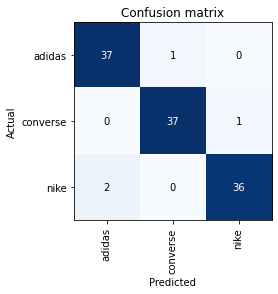

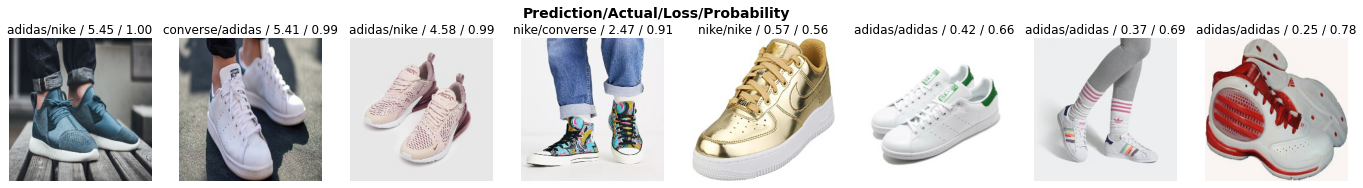

In [27]:
interp = ClassificationInterpretation.from_learner(best_learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(8, nrows=1)

In [29]:
best_learn.export("best_model.pkl")